In [1]:
import sys
sys.path.insert(0, '/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/hgru_clean/US/')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle
import random
from scipy import stats
import plotly.express as px
from sklearn.metrics import mean_squared_error, r2_score

import os
from pipeline_config import *
from utils import *
from typing import Dict, Tuple



In [3]:
Lr

0.01

In [4]:
#Seeds for reproducability:

torch.manual_seed(1)
np.random.seed(2)
random.seed(3)

In [5]:
with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/hgru_clean/US/basic/test_predictions.pickle', 'rb') as f:
    prediction_dic = pickle.load(f)

with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/hgru_clean/pickle_files/bi_directional_us_dataset_dict.pickle', 'rb') as f:
    raw_dataset_dict = pickle.load(f)
    
with open(category_id_to_category_name_path, 'rb') as f:
    category_id_to_name_dict = pickle.load(f)
    
with open(categories_per_indent_path, 'rb') as f:
    categories_per_indent_dict = pickle.load(f)
    
with open(test_dataset_path, 'rb') as f:
    test_dataset_dict = pickle.load(f)

with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/hgru_clean/US/data/train_mean_dict.pickle', 'rb') as f:
    train_mean_dict = pickle.load(f)

In [6]:
def create_test_dataframe(raw_dataset_dict: dict):
    test_dict = {}
    for key in raw_dataset_dict.keys():
    #for key in ['All items']:
        df = raw_dataset_dict[key][['Category', 'Date', 'Year', 'Indent', 'Inflation t+1']]
        df.dropna(inplace=True)
        df.rename(columns={'Inflation t+1': 'Actual'}, inplace=True)
        target_df = df[df['Year'] > Year]
        test_dict[key] = target_df
    return test_dict

test_dict = create_test_dataframe(raw_dataset_dict)


/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_265/1267119108.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)
/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_265/1267119108.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Inflation t+1': 'Actual'}, inplace=True)
/var/folders/88/mkn0vj0s1kl1179x22s6j2h80000gq/T/ipykernel_265/1267119108.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [7]:
def get_df_with_predictions(prediction_dic: dict, dict_of_categories_df:dict) -> dict:
    all_data_dict = {}
    for key in list(prediction_dic.keys()):
        predictions = prediction_dic[key]
        prediction_df =  pd.DataFrame(predictions.flatten().detach().numpy())
        prediction_df.rename(columns = {0: 'Prediction'}, inplace=True)
        dict_of_categories_df[key] = dict_of_categories_df[key].reset_index(drop=True)
        all_data_dict[key] = pd.concat([dict_of_categories_df[key], prediction_df], axis=1)
    return all_data_dict

all_data_test_dict=get_df_with_predictions(prediction_dic, test_dict)

In [8]:
# sanity check
all_categories = list(all_data_test_dict.keys())
len(all_categories)

350

Average RMSE:

Mean RMSE:  1.5901532685014137
RMSE std:  1.2260128647368427
Average MSE:  4.031694961825969
MSE std:  7.337330301326621


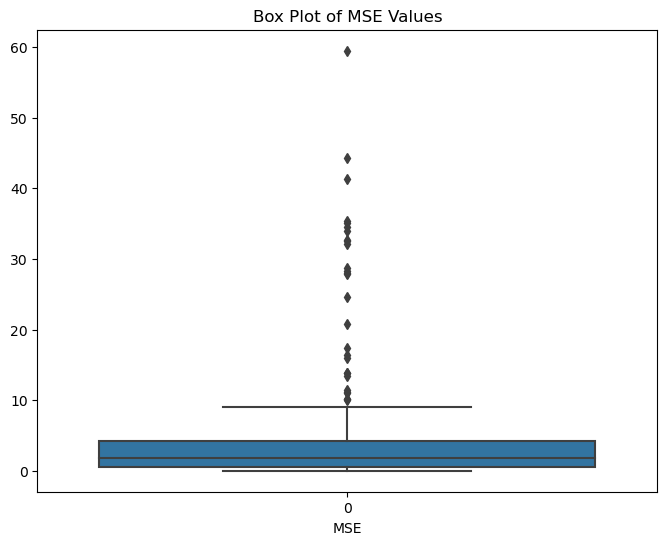

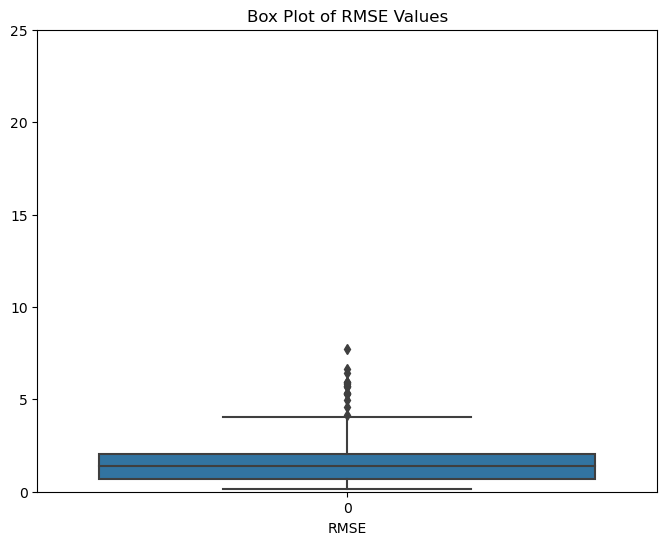

(1.5901532685014137, 1.2260128647368427)

In [9]:
import seaborn as sns

def avg_rmse(all_data_test_dict):
    mse_lst = []
    for key in all_categories:
        df_predictions = all_data_test_dict[key]
        y_pred = df_predictions['Prediction'].values
        y_actual = df_predictions['Actual'].values
        mse = mean_squared_error(y_pred, y_actual)
        mse_lst.append(mse)
    
    rmse_list = list(map(np.sqrt,mse_lst))
    avg_rmse = np.mean(rmse_list)
    avg_mse = np.mean(mse_lst)
    median_rmse = np.median(rmse_list)
    rmse_std = np.std(rmse_list)
    mse_std = np.std(mse_lst)
    
    print(f'Mean RMSE:  {avg_rmse}')
    #print(f'Median RMSE:  {median_rmse}')
    print(f'RMSE std:  {rmse_std}')
    print(f'Average MSE:  {avg_mse}')
    print(f'MSE std:  {mse_std}')

    # Create a box plot for RMSE values
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=mse_lst)
    plt.title('Box Plot of MSE Values')
    plt.xlabel('MSE')
    plt.show()

    # Create a box plot for RMSE values
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=rmse_list)
    plt.title('Box Plot of RMSE Values')
    plt.xlabel('RMSE')
    plt.ylim(0, 25)  # Adjust the range as needed to focus on a specific part of the data
    plt.show()

    return avg_rmse,rmse_std

avg_rmse(all_data_test_dict)

In [10]:
def create_rmse_dict(all_data_test_dict):
    rmse_dct = {'category':[],'model': 'I-GRU', 'RMSE_value':[] }
    for key in all_categories:
        df_predictions = all_data_test_dict[key]
        y_pred = df_predictions['Prediction'].values
        y_actual = df_predictions['Actual'].values
        mse = mean_squared_error(y_pred, y_actual)
        rmse = np.sqrt(mse)
        # Append directly to the lists
        rmse_dct['category'].append(key)
        rmse_dct['RMSE_value'].append(rmse)
    
    return pd.DataFrame(rmse_dct)
        

In [11]:
rmse_dict = create_rmse_dict(all_data_test_dict)
with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/Maya-Thesis---Baselines/Evaluation/i_gru_us_rmse_dict.pickle', 'wb') as handle:
    pickle.dump(rmse_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

Headline RMSE:

In [12]:
df_predictions = all_data_test_dict['All items']
y_pred = df_predictions['Prediction'].values
y_actual = df_predictions['Actual'].values
mse = mean_squared_error(y_pred, y_actual)
rmse = np.sqrt(mse)


print(f'rmse: {rmse}')

rmse: 0.348079118491967


In [13]:
print(f'y_pred: {y_pred}')
print(f'y_actual: {y_actual}')

y_pred: [ 0.27373338  0.22960383  0.32404047  0.33808798  0.6547897   0.53493863
  0.35456604  0.18373829  0.23718679  0.23679511  0.29168093  0.19000068
  0.7805031   0.4147816   0.7690196   0.8493601   0.8099235   0.33290625
  0.2381796   0.77080494  0.56463313  0.5156901   0.20829909  0.71258163
  0.35883477  0.5525582   0.4852598   0.42961848 -0.04605351  0.16277203
  0.23546733  0.60640883]
y_actual: [ 0.35402175  0.61823765  0.76708582  0.64215932  0.90078677  0.4727149
  0.27398935  0.4115879   0.93889903  0.77609622  0.46935007  0.61943716
  0.79454239  1.23311989  0.33138408  0.96908903  1.31357951 -0.01930244
  0.11812671  0.38522553  0.43744175  0.09624236 -0.07946874  0.80982923
  0.36932275  0.05302789  0.36710882  0.12404903  0.18019062  0.16672453
  0.62920172  0.3949496 ]


Total Correlation:

In [14]:
def total_corr(all_data_test_dict):
    corr_dict = {}
    for key in all_categories:
        df_predictions = all_data_test_dict[key]
        y_pred = df_predictions['Prediction'].values
        y_actual = df_predictions['Actual'].values
        corr = stats.pearsonr(y_pred,y_actual)[0]
        corr_dict[key] =  corr
    
    total_corr = sum(corr_dict.values())
    
    num_high_corr = 0
    for category in corr_dict:
        if corr_dict[category] >= 0.5:
            num_high_corr +=1
    
    print(f'Number of categories with High Correlation: {num_high_corr}')
    
    return total_corr

total_corr(all_data_test_dict)

Number of categories with High Correlation: 15


48.42374900469146

In [15]:
def total_corr_all_items(all_data_test_dict):
    corr_dict = {}
    for key in ['All items']:
        df_predictions = all_data_test_dict[key]
        y_pred = df_predictions['Prediction'].values
        y_actual = df_predictions['Actual'].values
        corr = stats.pearsonr(y_pred,y_actual)[0]
        corr_dict[key] =  corr
    
    total_corr = sum(corr_dict.values())
    
    num_high_corr = 0
    for category in corr_dict:
        if corr_dict[category] >= 0.5:
            num_high_corr +=1
    
    print(f'Number of categories with High Correlation: {num_high_corr}')
    
    return total_corr

total_corr_all_items(all_data_test_dict)

Number of categories with High Correlation: 0


0.347045244533793

In [16]:
def create_corr_dict(all_data_test_dict):
    corr_dct = {'category':[],'model': 'I-GRU', 'Pearson_Correlation':[] }
    for key in all_categories:
        df_predictions = all_data_test_dict[key]
        y_pred = df_predictions['Prediction'].values
        y_actual = df_predictions['Actual'].values
        corr = stats.pearsonr(y_pred,y_actual)[0]
        # Append directly to the lists
        corr_dct['category'].append(key)
        corr_dct['Pearson_Correlation'].append(corr)
    
    return pd.DataFrame(corr_dct)
        

In [17]:
corr_dct = create_corr_dict(all_data_test_dict)
with open('/Users/mvilenko/Library/CloudStorage/OneDrive-PayPal/Maya-Thesis---Baselines/Evaluation/i_gru_us_corr_dict.pickle', 'wb') as handle:
    pickle.dump(corr_dct, handle, protocol=pickle.HIGHEST_PROTOCOL)

Average R2:

In [18]:
def avg_r_squared(all_data_test_dict):
    r_squared_lst = []

    for key in all_categories:
        #print(f'category: {key}')
        df_predictions = all_data_test_dict[key]
        y_pred = df_predictions['Prediction'].values
        y_actual = df_predictions['Actual'].values
        r2 = r2_score(y_actual, y_pred)
        r_squared_lst.append(r2)

        if key =='All items':
            headline_r2 = r2
    
    avg_r2_score = np.mean(r_squared_lst)
    r2_std = np.std(r_squared_lst)
    
    print(f'Average R Squared:  {avg_r2_score}')
    print(f'R Squared std:  {r2_std}')
    print('--------------------------------------------------------')
    print(f'Headline R2: {headline_r2}')
    print(f'R2 list percentiles:\n[10: {np.percentile(r_squared_lst, 10)}, 25: {np.percentile(r_squared_lst, 25)}, 50: {np.percentile(r_squared_lst, 50)}, 75: {np.percentile(r_squared_lst, 75)}, 90: {np.percentile(r_squared_lst, 90)}]')

    return headline_r2, avg_r2_score

headline_r2, avg_r2_score = avg_r_squared(all_data_test_dict)

Average R Squared:  -1.2924793158038068
R Squared std:  4.812476225645053
--------------------------------------------------------
Headline R2: -0.017635819652991547
R2 list percentiles:
[10: -2.012458371056661, 25: -1.0198193079942137, 50: -0.4340478884360287, 75: -0.16325215820656175, 90: 0.07085984742442686]


In [19]:
def r2_time_series(all_data_test_dict, train_target_mean_dict):
    r_squared_lst = []

    for key in all_categories:
        df_predictions = all_data_test_dict[key]
        train_target_mean = train_target_mean_dict[key]
        y_pred = df_predictions['Prediction'].values
        y_actual = df_predictions['Actual'].values
        # Step 1: Calculate RSS (Residual Sum of Squares)
        rss = np.sum((y_actual - y_pred) ** 2)
        
        # Step 2: Calculate TSS (Total Sum of Squares) using lagged values (y_t-1 as the baseline)
        tss = np.sum((y_actual-train_target_mean)** 2)
        
        # Step 3: Calculate R^2
        r2 = 1 - (rss / tss)
        
        r_squared_lst.append(r2)
        if key =='All items':
            headline_r2 = r2
    
    avg_r2_score = np.mean(r_squared_lst)
    r2_std = np.std(r_squared_lst)
    
    print(f'Average R Squared:  {avg_r2_score}')
    print(f'R Squared std:  {r2_std}')
    print('--------------------------------------------------------')
    print(f'Headline R2: {headline_r2}')
    print(f'R2 list percentiles:\n[10: {np.percentile(r_squared_lst, 10)}, 25: {np.percentile(r_squared_lst, 25)}, 50: {np.percentile(r_squared_lst, 50)}, 75: {np.percentile(r_squared_lst, 75)}, 90: {np.percentile(r_squared_lst, 90)}]')

    return headline_r2, avg_r2_score

headline_r2, avg_r2_score = r2_time_series(all_data_test_dict, train_mean_dict)

Average R Squared:  -0.7305066565369762
R Squared std:  3.503447705103574
--------------------------------------------------------
Headline R2: 0.39432485179728594
R2 list percentiles:
[10: -1.247844532637129, 25: -0.6146047858463053, 50: -0.21968254118692943, 75: 0.0363686086234114, 90: 0.21384153870494668]


In [20]:
import dcor

def total_d_corr(all_data_test_dict):
    corr_dict = {}
    for key in all_categories:
        df_predictions = all_data_test_dict[key]
        y_pred = df_predictions['Prediction'].values
        y_actual = df_predictions['Actual'].values
        corr = dcor.distance_correlation(y_pred,y_actual)
        corr_dict[key] =  corr
    
    total_corr = sum(corr_dict.values())
    
    num_high_corr = 0
    for category in corr_dict:
        if corr_dict[category] >= 0.5:
            num_high_corr +=1
    
    print(f'Number of categories with High Correlation: {num_high_corr}')
    
    return total_corr

total_d_corr(all_data_test_dict)

/Users/mvilenko/opt/anaconda3/lib/python3.9/site-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float32, 1d, C), array(float64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


Number of categories with High Correlation: 21


118.38249405926386

In [21]:
import dcor

def headline_d_corr(all_data_test_dict):
    corr_dict = {}
    for key in ['All items']:
        df_predictions = all_data_test_dict[key]
        y_pred = df_predictions['Prediction'].values
        y_actual = df_predictions['Actual'].values
        corr = dcor.distance_correlation(y_pred,y_actual)
        corr_dict[key] =  corr
    
    total_corr = sum(corr_dict.values())
    
    num_high_corr = 0
    for category in corr_dict:
        if corr_dict[category] >= 0.5:
            num_high_corr +=1
    
    print(f'Number of categories with High Correlation: {num_high_corr}')
    
    return total_corr

headline_d_corr(all_data_test_dict)

Number of categories with High Correlation: 0


0.3506846072388319

Plot Results:

In [22]:
def plot_results(all_data_dict, categories):
    category_samples = ['All items']+random.sample(categories, 10)
    for category in category_samples:
        category_df = all_data_dict[category]
        fig = px.line(category_df, x="Date", y=["Actual", "Prediction"], title=f'{category} - Actual VS Prediction')
        fig.show()

plot_results(all_data_test_dict, all_categories)